In [68]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
!wget 'https://drive.google.com/uc?id=149EjiR3PUEmotXbtfDvYU_hBZPH8Kl3m' -O adm_data.csv

--2023-10-26 07:12:41--  https://drive.google.com/uc?id=149EjiR3PUEmotXbtfDvYU_hBZPH8Kl3m
Resolving drive.google.com (drive.google.com)... 142.251.8.113, 142.251.8.138, 142.251.8.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.8.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j2hmnbe3nrokt0kqkiid9hcmrmls4jmg/1698304350000/02611596255248067438/*/149EjiR3PUEmotXbtfDvYU_hBZPH8Kl3m?uuid=cea9c772-4d10-4cd4-9a4f-94fad9063d37 [following]
--2023-10-26 07:12:42--  https://doc-0k-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/j2hmnbe3nrokt0kqkiid9hcmrmls4jmg/1698304350000/02611596255248067438/*/149EjiR3PUEmotXbtfDvYU_hBZPH8Kl3m?uuid=cea9c772-4d10-4cd4-9a4f-94fad9063d37
Resolving doc-0k-84-docs.googleusercontent.com (doc-0k-84-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c06::84
Connecting to doc-0k-84-

In [3]:
DATASET_PATH = 'adm_data.csv'
PREPARED_DATASET_PATH_TRAIN = 'data_train.csv'
PREPARED_DATASET_PATH_TEST = 'data_test.csv'


SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

In [5]:
df = pd.read_csv('adm_data.csv', sep=',')
df.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


Проверяю типы данных (убеждаюсь что все int/float)

In [9]:
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

Проверяю пропуски.
Ожидал ,что будут пропуски в TOEFL, т.к. обычно не все студенты - носители иностранного языка, но пропусков не оказалось.

In [10]:
df.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

Посмотрим основные статистики по таблице

In [15]:
df.drop(columns=['Serial No.']).describe().round(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.00,400.00,400.00,400.00,400.00,400.00,400.00,400.00
mean,316.81,107.41,3.09,3.40,3.45,8.60,0.55,0.72
std,11.47,6.07,1.14,1.01,0.90,0.60,0.50,0.14
min,290.00,92.00,1.00,1.00,1.00,6.80,0.00,0.34
25%,308.00,103.00,2.00,2.50,3.00,8.17,0.00,0.64
50%,317.00,107.00,3.00,3.50,3.50,8.61,1.00,0.73
75%,325.00,112.00,4.00,4.00,4.00,9.06,1.00,0.83
max,340.00,120.00,5.00,5.00,5.00,9.92,1.00,0.97


Анализирую шансы поступления относительно кол-ва студентов.
На мой взгляд, выбросов нет.

Text(0.5, 0, 'Chance of Admit')

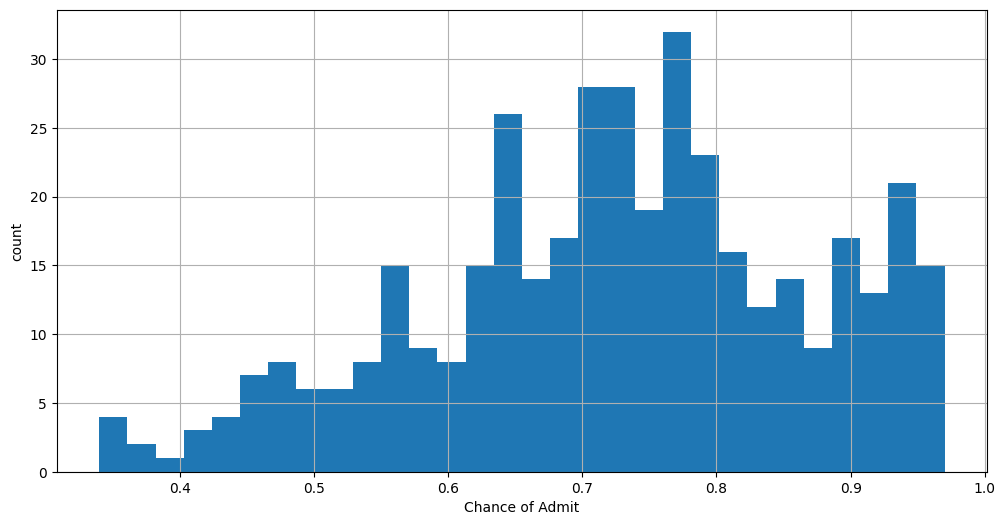

In [31]:
plt.figure(figsize=(12, 6))
df['Chance of Admit '].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Chance of Admit')

Разбиваем данные на Train и Test (70/30) и проверяем корректность разбиения по долям.

In [41]:
x = df.drop(columns=['Chance of Admit ', 'Serial No.'])
y = df['Chance of Admit ']

x_train_orig, x_test_orig, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=100)
x_train_orig.shape, x_test_orig.shape, x_train_orig.head()

((280, 7),
 (120, 7),
      GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research
 234        330          113                  5  5.0   4.0  9.31         1
 45         322          110                  5  5.0   4.0  9.10         1
 171        334          117                  5  4.0   4.5  9.07         1
 47         339          119                  5  4.5   4.0  9.70         0
 265        313          102                  3  2.5   2.5  8.68         0)

Стандартизация признаков:

In [42]:
feature_names_for_stand = x_train_orig.columns
scaler = StandardScaler()
x_train_orig[feature_names_for_stand] = scaler.fit_transform(x_train_orig[feature_names_for_stand])
x_test_orig[feature_names_for_stand] = scaler.transform(x_test_orig[feature_names_for_stand])

Сохранение:

In [44]:
x_train_orig.to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, sep=';')
x_test_orig.to_csv(PREPARED_DATASET_PATH_TEST, index=False, sep=';')

Функция для проверки качества модели:

In [59]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""

    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )

    plt.figure(figsize=(6, 6))

    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # диагональ, где true_values = pred_values

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')

    if save == True:
        plt.savefig('report.png')
    plt.show()

Обучение модели:

In [53]:
lr_model = LinearRegression()
lr_model.fit(x_train_orig, y_train)

LinearRegression()

Проверка качества модели на данных для обучения и тестовых данных.


In [63]:
y_train_preds = lr_model.predict(x_train_orig)
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=1)

R2:	0.802
RMSE:	0.064
MSE:	0.004


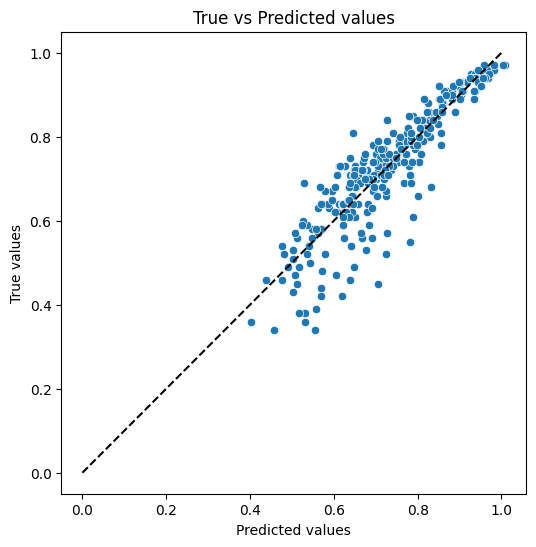

In [61]:
evaluate_preds(y_train, y_train_preds)

R2:	0.8
RMSE:	0.061
MSE:	0.004


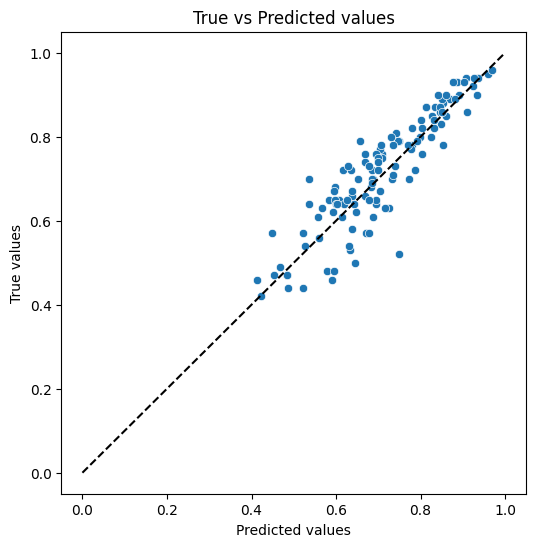

In [62]:
y_test_preds = lr_model.predict(x_test_orig)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=1)
evaluate_preds(y_test, y_test_preds)

Метрики модели получились хорошими, но все равно попробуем улучшить.

In [69]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(x_train_orig.iloc[:1])


array([[1.        , 1.12622009, 0.88728709, 1.67285672, 1.54425257,
        0.58484199, 1.13909383, 0.89155583, 0.99928054, 1.88400484,
        1.73916827, 0.6586608 , 1.28287035, 1.00408808, 1.48430418,
        1.37019538, 0.51892275, 1.01070325, 0.79106598, 2.5833133 ,
        0.97835685, 1.90554077, 1.49144516, 0.90314375, 1.75904858,
        1.37678738, 0.6661899 , 0.52141928, 1.01556574]])

In [70]:
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(interaction_only=True)
)

Качество модели ухудшилось (для тестовых данных):

R2:	0.821
RMSE:	0.061
MSE:	0.004


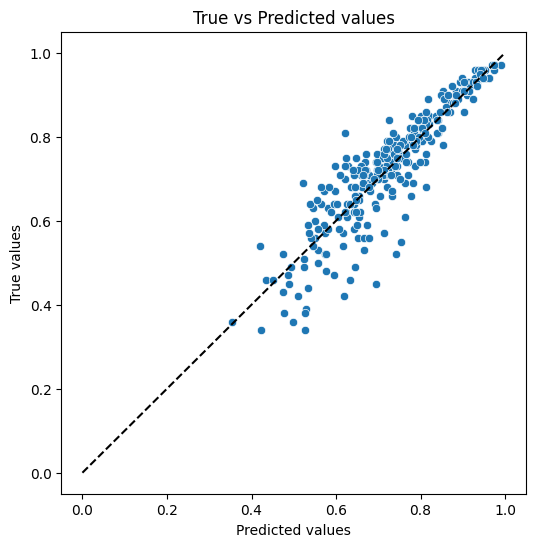

In [71]:
x_train_orig = pipe.fit_transform(x_train_orig)
x_test_orig = pipe.transform(x_test_orig)
lr_model = LinearRegression()
lr_model.fit(x_train_orig, y_train)
y_train_preds = lr_model.predict(x_train_orig)
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=1)
evaluate_preds(y_train, y_train_preds)

R2:	0.774
RMSE:	0.065
MSE:	0.004


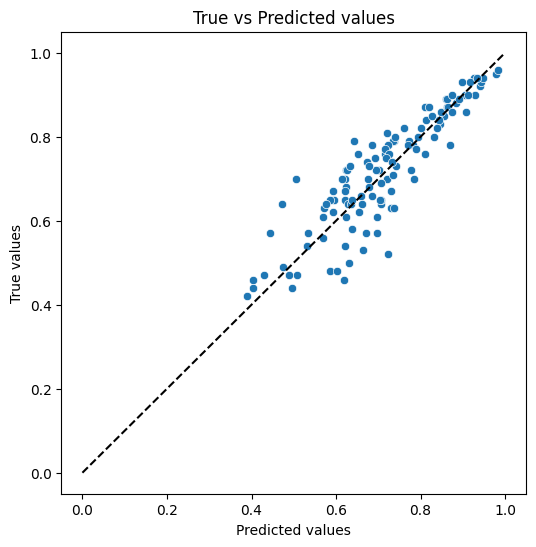

In [73]:
y_test_preds = lr_model.predict(x_test_orig)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=1)
evaluate_preds(y_test, y_test_preds)


Попробуем улучшить еще:

R2:	1.0
RMSE:	0.0
MSE:	0.0


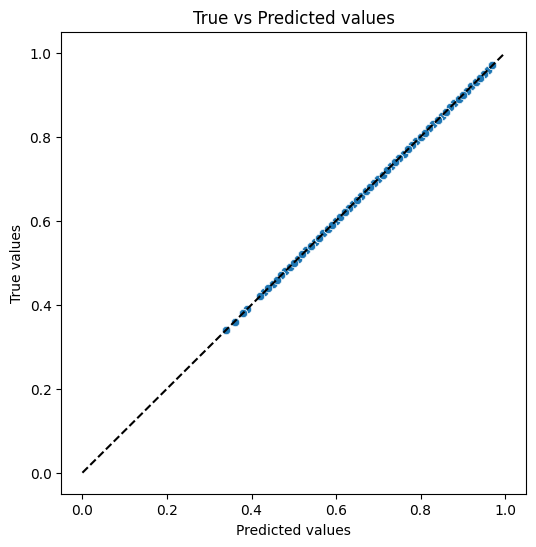

In [74]:
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=3)
)
x_train_orig = pipe.fit_transform(x_train_orig)
x_test_orig = pipe.transform(x_test_orig)
lr_model = LinearRegression()
lr_model.fit(x_train_orig, y_train)
y_train_preds = lr_model.predict(x_train_orig)
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=1)
evaluate_preds(y_train, y_train_preds)

R2:	-3.819
RMSE:	0.299
MSE:	0.09


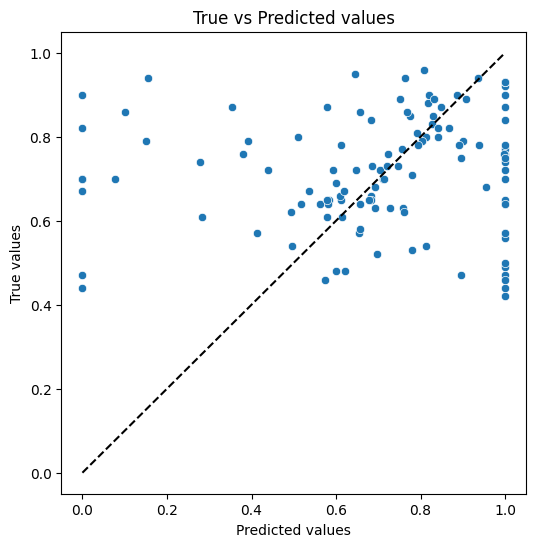

In [75]:
y_test_preds = lr_model.predict(x_test_orig)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=1)
evaluate_preds(y_test, y_test_preds)

По-итогу, из-за использования PolynomialFeatures я сильно переобучил модель.

Самые лучшие результаты показала моя самая первая обученная модель.

На тестовых данных она показала:

RMSE:	0.061 - означает, что средняя ошибка модели составляет 0.064
